In [1]:
ROOT = '../'

In [2]:
EMBPATH = ROOT + 'data/embeddings/'

### Binary - Commenting Dataset

In [3]:
DPATH = ROOT + 'data/safecity/binary/commenting/'

In [4]:
MPATH = ROOT + 'models/notebook5/commenting/'

### Binary - Groping Dataset

In [3]:
DPATH = ROOT + 'data/safecity/binary/groping/'

In [4]:
MPATH = ROOT + 'models/notebook5/groping/'

### Binary - Ogling Dataset

In [3]:
DPATH = ROOT + 'data/safecity/binary/ogling/'

In [4]:
MPATH = ROOT + 'models/notebook5/ogling/'

### Text Classifier

In [6]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

from torchtext import data, datasets, vocab

from sklearn.metrics import confusion_matrix

import random
import sys
import copy
from glob import glob
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
BATCH_SIZE = 128
FILTER_SIZES = [3, 4, 5]

In [8]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

In [9]:
import re, string
import spacy

nlp = spacy.load('en_core_web_sm')
punctuation = string.punctuation
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def cleanup(text):
    """
    Tokenization/text cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)
    text = re.sub(r"\'s", " \'s", text)
    text = re.sub(r"\'ve", " \'ve", text)
    text = re.sub(r"n\'t", " n\'t", text)
    text = re.sub(r"\'re", " \'re", text)
    text = re.sub(r"\'d", " \'d", text)
    text = re.sub(r"\'ll", " \'ll", text)
    text = re.sub(r",", " , ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\(", " \( ", text)
    text = re.sub(r"\)", " \) ", text)
    text = re.sub(r"\?", " \? ", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip()

def tokenizer(sentence):
    sentence = cleanup(sentence) # regex cleanup  
    tokens = nlp(sentence, disable=['parser', 'tagger', 'ner']) # tokenizer
    tokens = [tok.lemma_.lower().strip() for tok in tokens if tok.lemma_ != '-PRON-'] # lemmatizer
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuation] # punctuation removal

    if len(tokens) < FILTER_SIZES[-1]:
        tokens += ['<pad>']*(FILTER_SIZES[-1] - len(tokens))
        
    return tokens

In [10]:
text_field = data.Field(batch_first=True, lower=True, tokenize=tokenizer)
label_field = data.LabelField(dtype=torch.float)

In [11]:
fields = [('Description', text_field), ('Category', label_field)] # order must be same as cols of csv
trainset, validset, testset = data.TabularDataset.splits(
                                        path=DPATH,
                                        train='train.csv',
                                        validation='dev.csv',
                                        test='test.csv',
                                        format='csv',
                                        fields=fields,
                                        skip_header=True)

print(f'Trainset length: {len(trainset)}')
print(f'Validset length: {len(validset)}')
print(f'Testset length: {len(testset)}')

Trainset length: 7201
Validset length: 990
Testset length: 1701


In [12]:
vecs = vocab.Vectors('glove.6B.300d.txt', EMBPATH)

text_field.build_vocab(trainset, validset, testset, vectors=vecs) 
label_field.build_vocab(trainset, validset, testset)

In [13]:
trainloader, validloader, testloader = data.BucketIterator.splits(
                                  (trainset, validset, testset), 
                                  batch_sizes=[BATCH_SIZE]*3,
                                  sort_key=lambda x: len(x.Description),
                                  sort_within_batch=True, 
                                  shuffle=True, 
                                  repeat=False,
                                  device=device)

print(f"Train DL length: {len(trainloader)}")
print(f"Valid DL length: {len(validloader)}")
print(f"Test DL length: {len(testloader)}")

Train DL length: 57
Valid DL length: 8
Test DL length: 14


In [14]:
n_tokens = len(text_field.vocab)
n_classes = len(label_field.vocab)

print(f"Number of tokens: {n_tokens}")
print(f"Number of classes: {n_classes}")

Number of tokens: 8103
Number of classes: 2


In [15]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, 
                 filter_sizes, output_dim, padding_idx, dropout=0.4):
        super().__init__()
        
        # encoder
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim).from_pretrained(
                                        text_field.vocab.vectors, # freeze=True by default
                                        padding_idx=padding_idx)
        
        # concatenated convolutions
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels=embed_dim, 
                                              out_channels=n_filters,
                                              kernel_size=fs)
                                    for fs in filter_sizes
                                    ])
        
        # linear layer
        self.fc = nn.Linear(n_filters*len(filter_sizes), output_dim)
        
        # dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input x has shape (B, S) which is batch of sentences (sentence is list of word indices)
        x = self.embedding(x)
        x = self.dropout(x)
        # encoded input x has shape (B, S, E)
        
        x = x.permute(0, 2, 1)
        # x has shape (B, E, S)
        
        # conved
        conved = [F.relu(conv(x)) for conv in self.convs]
        # gives list of shapes (B, N, S - F_i + 1), where N is no of filters, F_i is ith filter size
        
        # pooled
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # gives list of shapes (B, N)
        
        out = torch.cat(pooled, dim=1)
        # shape (B, N*|F|), where |F| is the no of different filter sizes
        
        out = self.fc(self.dropout(out))
        # shape (B, 1)
        
        return out.squeeze(1) # out.shape = (B)

In [16]:
n_tokens, embed_dim = text_field.vocab.vectors.shape
pidx = text_field.vocab.stoi['<pad>']
(n_tokens, embed_dim, pidx)

(8103, 300, 1)

In [17]:
kw = {
    'vocab_size': n_tokens,
    'embed_dim': embed_dim,
    'n_filters': 192,
    'filter_sizes': FILTER_SIZES,
    'output_dim': 1,
    'padding_idx': pidx,
    'dropout': 0.5
}
model = CNN(**kw)

model.to(device)

CNN(
  (embedding): Embedding(8103, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 192, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 192, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 192, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=576, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, eps=1e-4, alpha=0.95, momentum=0.9, centered=True)

def accuracy(fx, y):
    ps = torch.sigmoid(fx)
    preds = torch.round(ps)
    return confusion_matrix(y.cpu().detach().view(-1), preds.cpu().detach().view(-1))

In [18]:
def train(model, iterator, criterion, optimizer, others=False):
    model.train()
    epoch_loss, epoch_acc = 0, 0

    for batch in iterator:
        x, y = batch.Description.to(device), batch.Category.to(device)
                
        fx = model(x)        
        loss = criterion(fx, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_acc += accuracy(fx, y)
        epoch_loss += loss.item()
    
    epoch_loss /= len(iterator)
    
    tn, fp, fn, tp = epoch_acc.ravel()
    acc = (tp + tn)/(tp + tn + fp + fn)
    if others is False:
        return epoch_loss, acc

    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1 = 2*tp/(2*tp + fp + fn)
    return epoch_loss, acc, prec, rec, f1 

In [19]:
def evaluate(model, iterator, criterion, others=False):
    model.eval()
    epoch_loss, epoch_acc = 0, 0
    
    with torch.no_grad():
        for batch in iterator:
            x, y = batch.Description.to(device), batch.Category.to(device)
            
            fx = model(x)
            loss = criterion(fx, y)
            
            epoch_acc += accuracy(fx, y)
            epoch_loss += loss.item()

    epoch_loss /= len(iterator)
    
    tn, fp, fn, tp = epoch_acc.ravel()
    acc = (tp + tn)/(tp + tn + fp + fn)
    if others is False:
        return epoch_loss, acc

    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1 = 2*tp/(2*tp + fp + fn)
    return epoch_loss, acc, prec, rec, f1 

In [20]:
best_model = type(model)(**kw).to(device)
best_name = None

In [21]:
text_field.vocab.itos[0:2]

['<unk>', '<pad>']

### Commenting

In [22]:
EPOCHS = 30
best_valid_acc = 0

train_losses = []
valid_losses = []

for e in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)

    # model progress
    print(f"Epoch: {e:02}/{EPOCHS}... "
          f"| Train Loss: {train_loss:.4f} "
          f"| Valid Loss: {valid_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} "
          f"| Valid Acc: {valid_acc:.4f}")
    
    if best_valid_acc < valid_acc:
        best_valid_acc = valid_acc

        filename = f'model-{e:02}-{train_loss:.3f}-{valid_loss:.3f}-{valid_acc:.3f}.pt'
#         torch.save(model.state_dict(), MPATH + filename)
        
        best_model.load_state_dict(model.state_dict())
        best_name = filename
    
    # for model complexity graph
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Done\n')
vl, vacc, vprec, vrec, vf1 = evaluate(best_model, validloader, criterion, others=True)
print(f'Valid: Loss {vl:.4f} | Acc {vacc:.4f} | Prec {vprec:.4f} | Rec {vrec:.4f} | F1 {vf1:.4f}')
tl, tacc, tprec, trec, tf1 = evaluate(best_model, testloader, criterion, others=True)
print(f'Test : Loss {tl:.4f} | Acc {tacc:.4f} | Prec {tprec:.4f} | Rec {trec:.4f} | F1 {tf1:.4f}')

Epoch: 01/30... | Train Loss: 0.5500 | Valid Loss: 0.4724 | Train Acc: 0.7286 | Valid Acc: 0.7929
Epoch: 02/30... | Train Loss: 0.4827 | Valid Loss: 0.4633 | Train Acc: 0.7899 | Valid Acc: 0.8051
Epoch: 03/30... | Train Loss: 0.4568 | Valid Loss: 0.4551 | Train Acc: 0.8041 | Valid Acc: 0.8040
Epoch: 04/30... | Train Loss: 0.4474 | Valid Loss: 0.4572 | Train Acc: 0.8071 | Valid Acc: 0.7939
Epoch: 05/30... | Train Loss: 0.4296 | Valid Loss: 0.4582 | Train Acc: 0.8153 | Valid Acc: 0.8010
Epoch: 06/30... | Train Loss: 0.4190 | Valid Loss: 0.4590 | Train Acc: 0.8154 | Valid Acc: 0.8081
Epoch: 07/30... | Train Loss: 0.4102 | Valid Loss: 0.4641 | Train Acc: 0.8214 | Valid Acc: 0.8040
Epoch: 08/30... | Train Loss: 0.3839 | Valid Loss: 0.4644 | Train Acc: 0.8386 | Valid Acc: 0.8071
Epoch: 09/30... | Train Loss: 0.3711 | Valid Loss: 0.4648 | Train Acc: 0.8414 | Valid Acc: 0.8111
Epoch: 10/30... | Train Loss: 0.3523 | Valid Loss: 0.4710 | Train Acc: 0.8507 | Valid Acc: 0.8071
Epoch: 11/30... | Tr

In [23]:
torch.save(best_model.state_dict(), MPATH + best_name)
best_name

'model-09-0.371-0.465-0.811.pt'

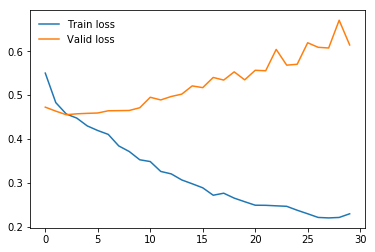

In [24]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)

# Time: 5s per epoch
# Accuracy: 81.1%

In [18]:
ls = glob(MPATH + '*')
ls.sort()
filename = ls[-1]
print(filename)

model = CNN(**kw).to(device)

model.load_state_dict(torch.load(filename, map_location=device))

../models/notebook5/commenting/model-09-0.371-0.465-0.811.pt


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
def predict(sentence):
    tokenized = tokenizer(sentence)
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    print(f'Tokenized: {tokenized}')
    print(f'Indexed: {indexed}')
    print(f'Tensor ({tensor.shape}): {tensor}')
    
    tensor = tensor.unsqueeze(0) # as we have used batch_first=True
    with torch.no_grad():
        model.eval()
        fx = model(tensor)

    print(f'Tensor w/ batch_size ({tensor.shape}): {tensor}')
    print(f'Logit Tensor ({fx.shape}): {fx}')
    return torch.sigmoid(fx).item()

In [20]:
predict("I had prying eyes on me this morning at the bus station")

Tokenized: ['pry', 'eye', 'morning', 'bus', 'station']
Indexed: [0, 313, 70, 9, 21]
Tensor (torch.Size([5])): tensor([  0, 313,  70,   9,  21], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 5])): tensor([[  0, 313,  70,   9,  21]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-0.6769], device='cuda:2')


0.33695870637893677

In [21]:
predict("I had a stalker this morning at the bus station")

Tokenized: ['stalker', 'morning', 'bus', 'station', '<pad>']
Indexed: [2639, 70, 9, 21, 1]
Tensor (torch.Size([5])): tensor([2639,   70,    9,   21,    1], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 5])): tensor([[2639,   70,    9,   21,    1]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-0.6561], device='cuda:2')


0.3416174054145813

In [22]:
predict("This person followed me at night and tried to sexually harass me")

Tokenized: ['person', 'follow', 'night', 'try', 'sexually', 'harass']
Indexed: [72, 16, 35, 13, 118, 65]
Tensor (torch.Size([6])): tensor([ 72,  16,  35,  13, 118,  65], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 72,  16,  35,  13, 118,  65]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.2769], device='cuda:2')


0.21807271242141724

In [23]:
predict("There were quite a few people passing lewd remarks at a young lady")

Tokenized: ['people', 'pass', 'lewd', 'remark', 'young', 'lady']
Indexed: [32, 14, 178, 347, 116, 66]
Tensor (torch.Size([6])): tensor([ 32,  14, 178, 347, 116,  66], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 32,  14, 178, 347, 116,  66]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([1.4528], device='cuda:2')


0.8104310631752014

In [24]:
predict("The person grabbed the woman's pubes in the park")

Tokenized: ['person', 'grab', 'woman', "'s", 'pubis', 'park']
Indexed: [72, 140, 50, 44, 6789, 124]
Tensor (torch.Size([6])): tensor([  72,  140,   50,   44, 6789,  124], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[  72,  140,   50,   44, 6789,  124]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.8670], device='cuda:2')


0.133891761302948

### Groping

In [22]:
EPOCHS = 30
best_valid_acc = 0

train_losses = []
valid_losses = []

for e in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)

    # model progress
    print(f"Epoch: {e:02}/{EPOCHS}... "
          f"| Train Loss: {train_loss:.4f} "
          f"| Valid Loss: {valid_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} "
          f"| Valid Acc: {valid_acc:.4f}")
    
    if best_valid_acc < valid_acc:
        best_valid_acc = valid_acc

        filename = f'model-{e:02}-{train_loss:.3f}-{valid_loss:.3f}-{valid_acc:.3f}.pt'
#         torch.save(model.state_dict(), MPATH + filename)
        
        best_model.load_state_dict(model.state_dict())
        best_name = filename
    
    # for model complexity graph
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Done\n')
vl, vacc, vprec, vrec, vf1 = evaluate(best_model, validloader, criterion, others=True)
print(f'Valid: Loss {vl:.4f} | Acc {vacc:.4f} | Prec {vprec:.4f} | Rec {vrec:.4f} | F1 {vf1:.4f}')
tl, tacc, tprec, trec, tf1 = evaluate(best_model, testloader, criterion, others=True)
print(f'Test : Loss {tl:.4f} | Acc {tacc:.4f} | Prec {tprec:.4f} | Rec {trec:.4f} | F1 {tf1:.4f}')

Epoch: 01/30... | Train Loss: 0.5089 | Valid Loss: 0.3949 | Train Acc: 0.7764 | Valid Acc: 0.8465
Epoch: 02/30... | Train Loss: 0.4028 | Valid Loss: 0.3801 | Train Acc: 0.8402 | Valid Acc: 0.8444
Epoch: 03/30... | Train Loss: 0.3733 | Valid Loss: 0.3648 | Train Acc: 0.8528 | Valid Acc: 0.8556
Epoch: 04/30... | Train Loss: 0.3480 | Valid Loss: 0.3563 | Train Acc: 0.8611 | Valid Acc: 0.8566
Epoch: 05/30... | Train Loss: 0.3270 | Valid Loss: 0.3503 | Train Acc: 0.8736 | Valid Acc: 0.8525
Epoch: 06/30... | Train Loss: 0.3277 | Valid Loss: 0.3479 | Train Acc: 0.8710 | Valid Acc: 0.8576
Epoch: 07/30... | Train Loss: 0.3104 | Valid Loss: 0.3610 | Train Acc: 0.8813 | Valid Acc: 0.8545
Epoch: 08/30... | Train Loss: 0.2939 | Valid Loss: 0.3509 | Train Acc: 0.8870 | Valid Acc: 0.8596
Epoch: 09/30... | Train Loss: 0.2782 | Valid Loss: 0.3506 | Train Acc: 0.8933 | Valid Acc: 0.8616
Epoch: 10/30... | Train Loss: 0.2725 | Valid Loss: 0.3611 | Train Acc: 0.8933 | Valid Acc: 0.8596
Epoch: 11/30... | Tr

In [23]:
torch.save(best_model.state_dict(), MPATH + best_name)
best_name

'model-22-0.178-0.408-0.866.pt'

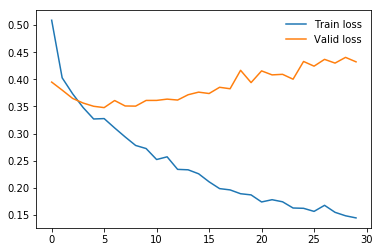

In [24]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)

# Time: 5s per epoch
# Accuracy: 86.07%

In [17]:
ls = glob(MPATH + '*')
ls.sort()
filename = ls[-1]
print(filename)

model = CNN(**kw).to(device)

model.load_state_dict(torch.load(filename, map_location=device))

../models/notebook5/groping/model-22-0.178-0.408-0.866.pt


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [18]:
def predict(sentence):
    tokenized = tokenizer(sentence)
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    print(f'Tokenized: {tokenized}')
    print(f'Indexed: {indexed}')
    print(f'Tensor ({tensor.shape}): {tensor}')
    
    tensor = tensor.unsqueeze(0) # as we have used batch_first=True
    with torch.no_grad():
        model.eval()
        fx = model(tensor)

    print(f'Tensor w/ batch_size ({tensor.shape}): {tensor}')
    print(f'Logit Tensor ({fx.shape}): {fx}')
    return torch.sigmoid(fx).item()

In [19]:
predict("I had prying eyes on me this morning at the bus station")

Tokenized: ['pry', 'eye', 'morning', 'bus', 'station']
Indexed: [0, 313, 70, 9, 21]
Tensor (torch.Size([5])): tensor([  0, 313,  70,   9,  21], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 5])): tensor([[  0, 313,  70,   9,  21]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.3962], device='cuda:2')


0.19842635095119476

In [20]:
predict("I had a stalker this morning at the bus station")

Tokenized: ['stalker', 'morning', 'bus', 'station', '<pad>']
Indexed: [2639, 70, 9, 21, 1]
Tensor (torch.Size([5])): tensor([2639,   70,    9,   21,    1], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 5])): tensor([[2639,   70,    9,   21,    1]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.4588], device='cuda:2')


0.188650980591774

In [21]:
predict("This person followed me at night and tried to sexually harass me")

Tokenized: ['person', 'follow', 'night', 'try', 'sexually', 'harass']
Indexed: [72, 16, 35, 13, 118, 65]
Tensor (torch.Size([6])): tensor([ 72,  16,  35,  13, 118,  65], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 72,  16,  35,  13, 118,  65]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-0.6245], device='cuda:2')


0.3487555682659149

In [22]:
predict("There were quite a few people passing lewd remarks at a young lady")

Tokenized: ['people', 'pass', 'lewd', 'remark', 'young', 'lady']
Indexed: [32, 14, 178, 347, 116, 66]
Tensor (torch.Size([6])): tensor([ 32,  14, 178, 347, 116,  66], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 32,  14, 178, 347, 116,  66]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-3.3072], device='cuda:2')


0.03532509505748749

In [23]:
predict("The person grabbed the woman's pubes in the park")

Tokenized: ['person', 'grab', 'woman', "'s", 'pubis', 'park']
Indexed: [72, 140, 50, 44, 6789, 124]
Tensor (torch.Size([6])): tensor([  72,  140,   50,   44, 6789,  124], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[  72,  140,   50,   44, 6789,  124]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([2.7482], device='cuda:2')


0.9398096203804016

### Ogling

In [22]:
EPOCHS = 30
best_valid_acc = 0

train_losses = []
valid_losses = []

for e in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)

    # model progress
    print(f"Epoch: {e:02}/{EPOCHS}... "
          f"| Train Loss: {train_loss:.4f} "
          f"| Valid Loss: {valid_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} "
          f"| Valid Acc: {valid_acc:.4f}")
    
    if best_valid_acc < valid_acc:
        best_valid_acc = valid_acc

        filename = f'model-{e:02}-{train_loss:.3f}-{valid_loss:.3f}-{valid_acc:.3f}.pt'
#         torch.save(model.state_dict(), MPATH + filename)
        
        best_model.load_state_dict(model.state_dict())
        best_name = filename
    
    # for model complexity graph
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Done\n')
vl, vacc, vprec, vrec, vf1 = evaluate(best_model, validloader, criterion, others=True)
print(f'Valid: Loss {vl:.4f} | Acc {vacc:.4f} | Prec {vprec:.4f} | Rec {vrec:.4f} | F1 {vf1:.4f}')
tl, tacc, tprec, trec, tf1 = evaluate(best_model, testloader, criterion, others=True)
print(f'Test : Loss {tl:.4f} | Acc {tacc:.4f} | Prec {tprec:.4f} | Rec {trec:.4f} | F1 {tf1:.4f}')

Epoch: 01/30... | Train Loss: 0.5186 | Valid Loss: 0.4412 | Train Acc: 0.8003 | Valid Acc: 0.8263
Epoch: 02/30... | Train Loss: 0.4423 | Valid Loss: 0.4199 | Train Acc: 0.8196 | Valid Acc: 0.8313
Epoch: 03/30... | Train Loss: 0.4211 | Valid Loss: 0.4177 | Train Acc: 0.8292 | Valid Acc: 0.8343
Epoch: 04/30... | Train Loss: 0.4119 | Valid Loss: 0.4146 | Train Acc: 0.8286 | Valid Acc: 0.8323
Epoch: 05/30... | Train Loss: 0.3981 | Valid Loss: 0.4098 | Train Acc: 0.8364 | Valid Acc: 0.8364
Epoch: 06/30... | Train Loss: 0.3875 | Valid Loss: 0.4178 | Train Acc: 0.8384 | Valid Acc: 0.8374
Epoch: 07/30... | Train Loss: 0.3629 | Valid Loss: 0.4118 | Train Acc: 0.8489 | Valid Acc: 0.8374
Epoch: 08/30... | Train Loss: 0.3586 | Valid Loss: 0.4111 | Train Acc: 0.8484 | Valid Acc: 0.8404
Epoch: 09/30... | Train Loss: 0.3488 | Valid Loss: 0.4169 | Train Acc: 0.8529 | Valid Acc: 0.8343
Epoch: 10/30... | Train Loss: 0.3273 | Valid Loss: 0.4178 | Train Acc: 0.8606 | Valid Acc: 0.8333
Epoch: 11/30... | Tr

In [23]:
torch.save(best_model.state_dict(), MPATH + best_name)
best_name

'model-08-0.359-0.411-0.840.pt'

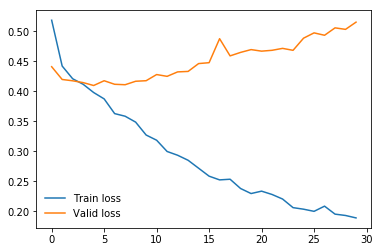

In [24]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)

# Time: 5s per epoch
# Accuracy: 82.13%

In [18]:
ls = glob(MPATH + '*')
ls.sort()
filename = ls[-1]
print(filename)

model = CNN(**kw).to(device)

model.load_state_dict(torch.load(filename, map_location=device))

../models/notebook5/ogling/model-08-0.359-0.411-0.840.pt


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [20]:
def predict(sentence):
    tokenized = tokenizer(sentence)
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    print(f'Tokenized: {tokenized}')
    print(f'Indexed: {indexed}')
    print(f'Tensor ({tensor.shape}): {tensor}')
    
    tensor = tensor.unsqueeze(0) # as we have used batch_first=True
    with torch.no_grad():
        model.eval()
        fx = model(tensor)

    print(f'Tensor w/ batch_size ({tensor.shape}): {tensor}')
    print(f'Logit Tensor ({fx.shape}): {fx}')
    return torch.sigmoid(fx).item()

In [22]:
predict("I had prying eyes on me this morning at the bus station")

Tokenized: ['pry', 'eye', 'morning', 'bus', 'station']
Indexed: [0, 313, 70, 9, 21]
Tensor (torch.Size([5])): tensor([  0, 313,  70,   9,  21], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 5])): tensor([[  0, 313,  70,   9,  21]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-0.2422], device='cuda:2')


0.43973425030708313

In [23]:
predict("I had a stalker this morning at the bus station")

Tokenized: ['stalker', 'morning', 'bus', 'station', '<pad>']
Indexed: [2639, 70, 9, 21, 1]
Tensor (torch.Size([5])): tensor([2639,   70,    9,   21,    1], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 5])): tensor([[2639,   70,    9,   21,    1]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.3481], device='cuda:2')


0.20617835223674774

In [24]:
predict("This person followed me at night and tried to sexually harass me")

Tokenized: ['person', 'follow', 'night', 'try', 'sexually', 'harass']
Indexed: [72, 16, 35, 13, 118, 65]
Tensor (torch.Size([6])): tensor([ 72,  16,  35,  13, 118,  65], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 72,  16,  35,  13, 118,  65]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-2.0465], device='cuda:2')


0.11440831422805786

In [25]:
predict("There were quite a few people passing lewd remarks at a young lady")

Tokenized: ['people', 'pass', 'lewd', 'remark', 'young', 'lady']
Indexed: [32, 14, 178, 347, 116, 66]
Tensor (torch.Size([6])): tensor([ 32,  14, 178, 347, 116,  66], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 32,  14, 178, 347, 116,  66]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.5139], device='cuda:2')


0.1803557425737381

In [26]:
predict("The person grabbed the woman's pubes in the park")

Tokenized: ['person', 'grab', 'woman', "'s", 'pubis', 'park']
Indexed: [72, 140, 50, 44, 6789, 124]
Tensor (torch.Size([6])): tensor([  72,  140,   50,   44, 6789,  124], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[  72,  140,   50,   44, 6789,  124]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-3.5342], device='cuda:2')


0.028354482725262642